In [1]:
import torch as tc 
from torch import optim, nn 
from torch.utils.data import TensorDataset, DataLoader, random_split 

from torchvision import models, datasets 
from torchvision import transforms as T

from torchmetrics import Accuracy 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm import tqdm 

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = datasets.ImageFolder('/home/ahmadrezabaqerzadeh/datasets/skin cancer detection using cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train', 
                            transform = T.Compose([T.ToTensor(),
                                                   T.Resize(size = (64, 64))]))

In [3]:
t, _ = random_split(data, (300, len(data)-300), generator = tc.Generator().manual_seed(42))

In [4]:
train_dataset, valid_dataset = random_split(t, (250, len(t)-250), generator = tc.Generator().manual_seed(42))

In [5]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 50, shuffle = False)

In [6]:
model = models.resnet152(pretrained = True)

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
num_classes = 9

In [8]:
model.fc = nn.LazyLinear(num_classes)

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
model 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
device = 'cuda' if tc.cuda.is_available() else 'cpu' 

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def train_one_epoch(model, train_loader, loss_func, optimizer, epoch):
    model.train()

    train_loss=AverageMeter()
    train_acc=Accuracy(task='multiclass', num_classes=9).to(device)

    with tqdm(train_loader, unit='batch') as tepoch:
        for x, y in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')

            x=x.to(device)
            y=y.to(device)

            yp=model(x)
        
            loss=loss_func(yp.squeeze(),  y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss.item())
            train_acc(yp.squeeze(), y.int())

            tepoch.set_postfix(loss=train_loss.avg, Accuracy=train_acc.compute().item() * 100)

    return model, train_loss.avg, train_acc.compute().item()

In [13]:
def validation(model, valid_loaedr, loss_func):
    model.eval()

    valid_loss=AverageMeter()
    valid_acc=Accuracy(task='multiclass', num_classes=9).to(device)

    for x, y in valid_loaedr:

        x=x.to(device)
        y=y.to(device)

        yp=model(x)
        loss=loss_func(yp.squeeze(), y)

        valid_loss.update(loss.item())
        valid_acc(yp.squeeze(), y)

    print(f'valid loss={valid_loss.avg:.4}, accuracy={valid_acc.compute().item() * 100 :.4}')
    print()

    return valid_loss.avg, valid_acc.compute().item()

In [14]:
x, y = next(iter(train_loader))

In [15]:
x.shape

torch.Size([64, 3, 64, 64])

In [16]:
y.shape

torch.Size([64])

In [24]:
model = model.to(device)

In [25]:
model(x.to(device)).shape

torch.Size([64, 9])

In [26]:
yp = model(x.to(device))

nn.CrossEntropyLoss()(yp.squeeze(), y.to(device))

tensor(2.3731, device='cuda:0', grad_fn=<NllLossBackward0>)

In [27]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001, betas = [0.9, 0.99], weight_decay = 1e-4)
loss_func = nn.CrossEntropyLoss()

In [28]:
loss_train_hist, acc_train_hist = [], []
loss_valid_hist, acc_valid_hist = [], []

best_loss = tc.inf 
best_model = [0]

In [29]:
N = 35
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 4/4 [00:08<00:00,  2.13s/batch, Accuracy=17.2, loss=2.19]


valid loss=2.192, accuracy=14.0

model saved!


Epoch=1: 100%|██████████| 4/4 [00:09<00:00,  2.38s/batch, Accuracy=81.2, loss=1.26]


valid loss=2.114, accuracy=18.0

model saved!


Epoch=2: 100%|██████████| 4/4 [00:09<00:00,  2.37s/batch, Accuracy=94, loss=0.688]  


valid loss=1.998, accuracy=26.0

model saved!


Epoch=3: 100%|██████████| 4/4 [00:09<00:00,  2.29s/batch, Accuracy=96.8, loss=0.376]


valid loss=1.866, accuracy=30.0

model saved!


Epoch=4: 100%|██████████| 4/4 [00:09<00:00,  2.34s/batch, Accuracy=97.6, loss=0.201]


valid loss=1.741, accuracy=42.0

model saved!


Epoch=5: 100%|██████████| 4/4 [00:09<00:00,  2.38s/batch, Accuracy=98, loss=0.14]   


valid loss=1.69, accuracy=38.0

model saved!


Epoch=6: 100%|██████████| 4/4 [00:09<00:00,  2.37s/batch, Accuracy=98.4, loss=0.0897]


valid loss=1.617, accuracy=42.0

model saved!


Epoch=7: 100%|██████████| 4/4 [00:09<00:00,  2.39s/batch, Accuracy=98.4, loss=0.0543]


valid loss=1.615, accuracy=46.0

model saved!


Epoch=8: 100%|██████████| 4/4 [00:09<00:00,  2.48s/batch, Accuracy=98.8, loss=0.0425]


valid loss=1.635, accuracy=48.0



Epoch=9: 100%|██████████| 4/4 [00:09<00:00,  2.40s/batch, Accuracy=98.8, loss=0.0358]


valid loss=1.645, accuracy=48.0



Epoch=10: 100%|██████████| 4/4 [00:09<00:00,  2.48s/batch, Accuracy=98.8, loss=0.0312]


valid loss=1.637, accuracy=50.0



Epoch=11: 100%|██████████| 4/4 [00:09<00:00,  2.38s/batch, Accuracy=98.8, loss=0.0299]


valid loss=1.635, accuracy=46.0



Epoch=12: 100%|██████████| 4/4 [00:10<00:00,  2.55s/batch, Accuracy=98.8, loss=0.0257]


valid loss=1.641, accuracy=50.0



Epoch=13: 100%|██████████| 4/4 [00:10<00:00,  2.55s/batch, Accuracy=98.8, loss=0.0308]


valid loss=1.658, accuracy=52.0



Epoch=14: 100%|██████████| 4/4 [00:09<00:00,  2.49s/batch, Accuracy=98.8, loss=0.0267]


valid loss=1.667, accuracy=54.0



Epoch=15: 100%|██████████| 4/4 [00:10<00:00,  2.56s/batch, Accuracy=98.8, loss=0.0248]


valid loss=1.673, accuracy=52.0



Epoch=16: 100%|██████████| 4/4 [00:09<00:00,  2.31s/batch, Accuracy=98, loss=0.0465]  


valid loss=1.688, accuracy=52.0



Epoch=17: 100%|██████████| 4/4 [00:10<00:00,  2.61s/batch, Accuracy=98, loss=0.0332]  


valid loss=1.694, accuracy=52.0



Epoch=18: 100%|██████████| 4/4 [00:10<00:00,  2.69s/batch, Accuracy=98.4, loss=0.029] 


valid loss=1.701, accuracy=52.0



Epoch=19: 100%|██████████| 4/4 [00:09<00:00,  2.31s/batch, Accuracy=98.8, loss=0.0241]


valid loss=1.7, accuracy=52.0



Epoch=20: 100%|██████████| 4/4 [00:10<00:00,  2.52s/batch, Accuracy=98.8, loss=0.0225]


valid loss=1.697, accuracy=52.0



Epoch=21: 100%|██████████| 4/4 [00:09<00:00,  2.41s/batch, Accuracy=98.4, loss=0.0236]


valid loss=1.689, accuracy=54.0



Epoch=22: 100%|██████████| 4/4 [00:09<00:00,  2.35s/batch, Accuracy=98.8, loss=0.0225]


valid loss=1.689, accuracy=54.0



Epoch=23: 100%|██████████| 4/4 [00:09<00:00,  2.49s/batch, Accuracy=98, loss=0.0247]  


valid loss=1.682, accuracy=54.0



Epoch=24: 100%|██████████| 4/4 [00:10<00:00,  2.52s/batch, Accuracy=98.8, loss=0.02]  


valid loss=1.669, accuracy=56.0



Epoch=25: 100%|██████████| 4/4 [00:09<00:00,  2.36s/batch, Accuracy=98.4, loss=0.0243]


valid loss=1.663, accuracy=56.0



Epoch=26: 100%|██████████| 4/4 [00:09<00:00,  2.35s/batch, Accuracy=98, loss=0.0249]  


valid loss=1.659, accuracy=56.0



Epoch=27: 100%|██████████| 4/4 [00:09<00:00,  2.48s/batch, Accuracy=98.4, loss=0.0227]


valid loss=1.66, accuracy=56.0



Epoch=28: 100%|██████████| 4/4 [00:10<00:00,  2.56s/batch, Accuracy=98.8, loss=0.0201]


valid loss=1.678, accuracy=56.0



Epoch=29: 100%|██████████| 4/4 [00:10<00:00,  2.54s/batch, Accuracy=98.4, loss=0.023] 


valid loss=1.687, accuracy=56.0



Epoch=30: 100%|██████████| 4/4 [00:09<00:00,  2.38s/batch, Accuracy=99.2, loss=0.0181]


valid loss=1.695, accuracy=56.0



Epoch=31: 100%|██████████| 4/4 [00:10<00:00,  2.55s/batch, Accuracy=99.2, loss=0.0186]


valid loss=1.699, accuracy=56.0



Epoch=32: 100%|██████████| 4/4 [00:10<00:00,  2.57s/batch, Accuracy=98.4, loss=0.0216]


valid loss=1.702, accuracy=56.0



Epoch=33: 100%|██████████| 4/4 [00:10<00:00,  2.55s/batch, Accuracy=98.4, loss=0.0228]


valid loss=1.708, accuracy=56.0



Epoch=34: 100%|██████████| 4/4 [00:10<00:00,  2.53s/batch, Accuracy=98.4, loss=0.0194]


valid loss=1.714, accuracy=54.0



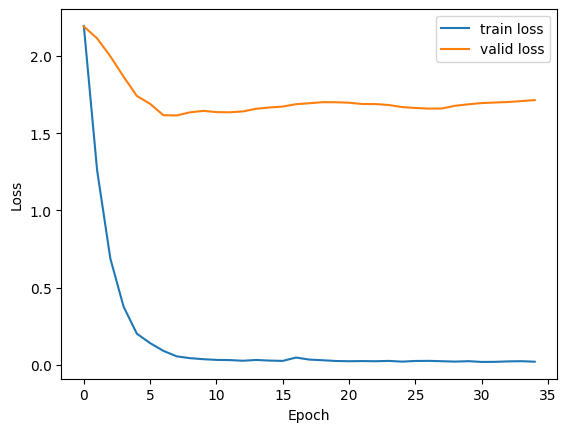

In [31]:
plt.plot(range(N), loss_train_hist, label = 'train loss')
plt.plot(range(N), loss_valid_hist, label = 'valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
model = models.DenseNet(num_classes=9).to(device)

In [42]:
model.fc = nn.LazyLinear(9).to(device)

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [43]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001, betas = [0.9, 0.99], weight_decay = 1e-4)
loss_func = nn.CrossEntropyLoss()

In [44]:
loss_train_hist, acc_train_hist = [], []
loss_valid_hist, acc_valid_hist = [], []

best_loss = tc.inf 
best_model = [0]

In [45]:
N = 35
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 4/4 [00:03<00:00,  1.12batch/s, Accuracy=14.4, loss=2.15]


valid loss=2.189, accuracy=14.0

model saved!


Epoch=1: 100%|██████████| 4/4 [00:03<00:00,  1.14batch/s, Accuracy=46.4, loss=1.86]


valid loss=2.16, accuracy=16.0

model saved!


Epoch=2: 100%|██████████| 4/4 [00:03<00:00,  1.17batch/s, Accuracy=54, loss=1.69]  


valid loss=2.114, accuracy=22.0

model saved!


Epoch=3: 100%|██████████| 4/4 [00:03<00:00,  1.19batch/s, Accuracy=59.2, loss=1.53]


valid loss=2.05, accuracy=24.0

model saved!


Epoch=4: 100%|██████████| 4/4 [00:03<00:00,  1.23batch/s, Accuracy=63.2, loss=1.38]


valid loss=1.981, accuracy=26.0

model saved!


Epoch=5: 100%|██████████| 4/4 [00:03<00:00,  1.22batch/s, Accuracy=62.8, loss=1.28]


valid loss=1.917, accuracy=30.0

model saved!


Epoch=6: 100%|██████████| 4/4 [00:03<00:00,  1.17batch/s, Accuracy=64.8, loss=1.21]


valid loss=1.847, accuracy=40.0

model saved!


Epoch=7: 100%|██████████| 4/4 [00:03<00:00,  1.19batch/s, Accuracy=71.6, loss=1.06]


valid loss=1.783, accuracy=44.0

model saved!


Epoch=8: 100%|██████████| 4/4 [00:03<00:00,  1.21batch/s, Accuracy=75.6, loss=0.952]


valid loss=1.741, accuracy=42.0

model saved!


Epoch=9: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s, Accuracy=84, loss=0.812]  


valid loss=1.701, accuracy=36.0

model saved!


Epoch=10: 100%|██████████| 4/4 [00:03<00:00,  1.19batch/s, Accuracy=88, loss=0.734]  


valid loss=1.682, accuracy=36.0

model saved!


Epoch=11: 100%|██████████| 4/4 [00:03<00:00,  1.19batch/s, Accuracy=90.4, loss=0.686]


valid loss=1.66, accuracy=36.0

model saved!


Epoch=12: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s, Accuracy=91.6, loss=0.61] 


valid loss=1.671, accuracy=36.0



Epoch=13: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s, Accuracy=94.8, loss=0.488]


valid loss=1.681, accuracy=38.0



Epoch=14: 100%|██████████| 4/4 [00:03<00:00,  1.20batch/s, Accuracy=93.6, loss=0.479]


valid loss=1.672, accuracy=38.0



Epoch=15: 100%|██████████| 4/4 [00:03<00:00,  1.15batch/s, Accuracy=96, loss=0.378]  


valid loss=1.663, accuracy=40.0



Epoch=16: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s, Accuracy=98, loss=0.321]  


valid loss=1.673, accuracy=42.0



Epoch=17: 100%|██████████| 4/4 [00:03<00:00,  1.14batch/s, Accuracy=98, loss=0.296]  


valid loss=1.683, accuracy=42.0



Epoch=18: 100%|██████████| 4/4 [00:03<00:00,  1.15batch/s, Accuracy=98.4, loss=0.217]


valid loss=1.686, accuracy=44.0



Epoch=19: 100%|██████████| 4/4 [00:03<00:00,  1.20batch/s, Accuracy=98.8, loss=0.178]


valid loss=1.705, accuracy=44.0



Epoch=20: 100%|██████████| 4/4 [00:03<00:00,  1.15batch/s, Accuracy=98.8, loss=0.159]


valid loss=1.72, accuracy=44.0



Epoch=21: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s, Accuracy=98.4, loss=0.138]


valid loss=1.731, accuracy=44.0



Epoch=22: 100%|██████████| 4/4 [00:03<00:00,  1.20batch/s, Accuracy=98, loss=0.135]  


valid loss=1.724, accuracy=44.0



Epoch=23: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s, Accuracy=98.8, loss=0.111]


valid loss=1.733, accuracy=44.0



Epoch=24: 100%|██████████| 4/4 [00:03<00:00,  1.21batch/s, Accuracy=99.6, loss=0.108]


valid loss=1.746, accuracy=44.0



Epoch=25: 100%|██████████| 4/4 [00:03<00:00,  1.14batch/s, Accuracy=99.2, loss=0.0898]


valid loss=1.777, accuracy=44.0



Epoch=26: 100%|██████████| 4/4 [00:03<00:00,  1.14batch/s, Accuracy=98.4, loss=0.0822]


valid loss=1.808, accuracy=44.0



Epoch=27: 100%|██████████| 4/4 [00:03<00:00,  1.14batch/s, Accuracy=98.4, loss=0.0862]


valid loss=1.814, accuracy=44.0



Epoch=28: 100%|██████████| 4/4 [00:03<00:00,  1.12batch/s, Accuracy=99.2, loss=0.069] 


valid loss=1.828, accuracy=46.0



Epoch=29: 100%|██████████| 4/4 [00:03<00:00,  1.06batch/s, Accuracy=98.4, loss=0.0687]


valid loss=1.831, accuracy=46.0



Epoch=30: 100%|██████████| 4/4 [00:03<00:00,  1.26batch/s, Accuracy=99.2, loss=0.0689]


valid loss=1.815, accuracy=46.0



Epoch=31: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s, Accuracy=98.4, loss=0.0713]


valid loss=1.804, accuracy=48.0



Epoch=32: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s, Accuracy=98.4, loss=0.0622]


valid loss=1.817, accuracy=46.0



Epoch=33: 100%|██████████| 4/4 [00:03<00:00,  1.22batch/s, Accuracy=98.8, loss=0.0527]


valid loss=1.846, accuracy=48.0



Epoch=34: 100%|██████████| 4/4 [00:03<00:00,  1.30batch/s, Accuracy=98.8, loss=0.0452]


valid loss=1.87, accuracy=44.0



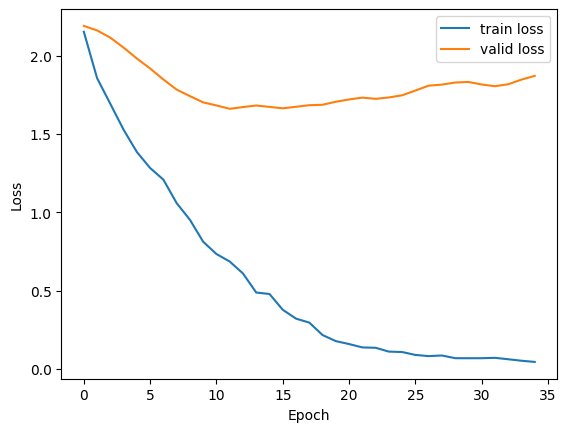

In [46]:
plt.plot(range(N), loss_train_hist, label = 'train loss')
plt.plot(range(N), loss_valid_hist, label = 'valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()